# Statistical Properties of the Complete Intersection Calabi Yau three-folds Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
import seaborn as sns
#plt.style.use('seaborn')
plt.style.use('ggplot')
pd.options.display.max_columns=50
from sklearn.decomposition import PCA
from cicyutils import CicyPad

In [2]:
# Load the dataset and enumerate the keys
cicy=pd.read_hdf('cicy3.h5')
cicy.keys()

Index(['matrix', 'h11', 'h21', 'euler', 'c2', 'num_cp', 'num_eqs',
       'rank_matrix', 'norm_matrix'],
      dtype='object')

## Explanation of the keys:
The variables $h^{1,1}$, $h^{2,1}$ and $C_2$ are the _target variables_. These encode the topological data of the CICY 3-folds.

Further, the Euler number $\chi$ is determined in terms of the Hodge numbers _via_
\begin{equation}
\chi = 2\left(h^{1,1}-h^{2,1}\right)
\end{equation}

A classic problem in machine learning algebraic geometry and string theory is the prediction of these target variables given
input configuration matrices.

We now enumerate the properties of each of the entries in the dataset.

**c2**: vector of integers, length varies from 15 to 1. Entries are sampled from {0, 24, 36, 40, 44, 48, 50, 52, 54, 56, 60, 64, 72}

**h11**: integer, ranging from 0 to 19

**h21**: Hodge number ranging from 0 to 101

**matrix**: the _configuration matrix_ $Q$ which we treat as analogues of MNIST images (say)

**euler**: Euler number $\chi = 2\left(h^{1,1}-h^{2,1}\right)$

**num_cp**: integer ranging from 1 to 15. value equals the length of the $c_2$ tuple, equivalenty, number of rows of _matrix_

**num_eqs**: integer ranging from 1 to 18, value equals number of columns of _matrix_

**rank_matrix** and **norm_matrix** are respectively the rank and Froebenius norm. We discuss them later.

## Statistics of Target Variables

We describe how the target variables of the dataset, i.e. $h^{1,1}$, $h^{2,1}$ and $c_2$ are distributed.

These plots show that the CICY3 dataset is quite skewed, with some classes being heavily populated, while others are sparsely populated.

This is one of the principal challenges in machine learning this dataset.

In [3]:
from collections import Counter
from itertools import chain

In [4]:
h11_unique,h21_unique = np.unique(cicy['h11']), np.unique(cicy['h21'])
h11_population,h21_population = np.bincount(cicy['h11']), np.bincount(cicy['h21'])

h11h21pairs = list(zip(cicy['h11'],cicy['h21']))

h11h21pop = Counter(chain(h11h21pairs)).values()

n_unique_pairs = len(h11h21pop)

c2_values = cicy['c2'].sum()
unique_c2 = np.unique(c2_values)
c2_counts = [c for c in np.bincount(c2_values) if c!=0]

c2_arr=cicy['c2'].apply(tuple) # tuple makes entries hashable so Counter can work
c2_pop_entries = Counter(c2_arr).values() #population of every unique entry
n_unique_entries = len(c2_pop_entries)

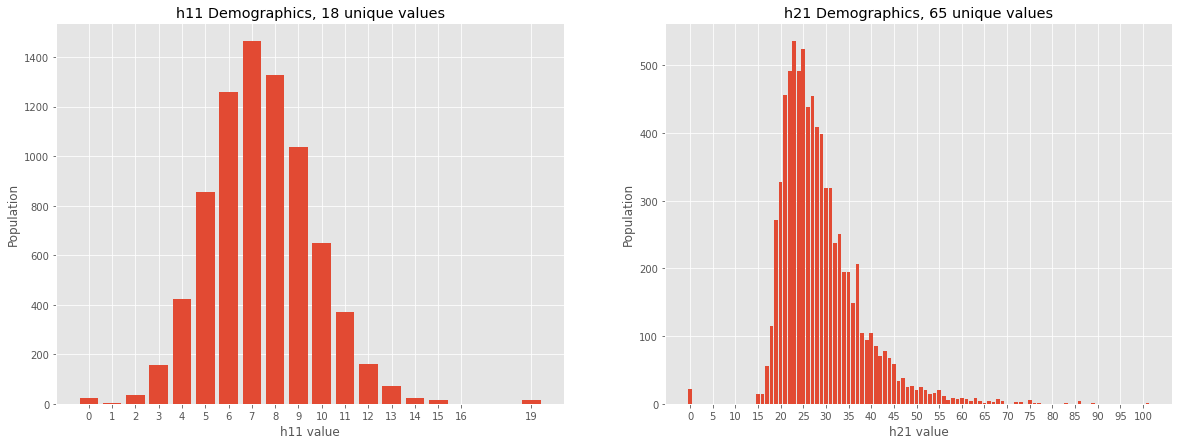

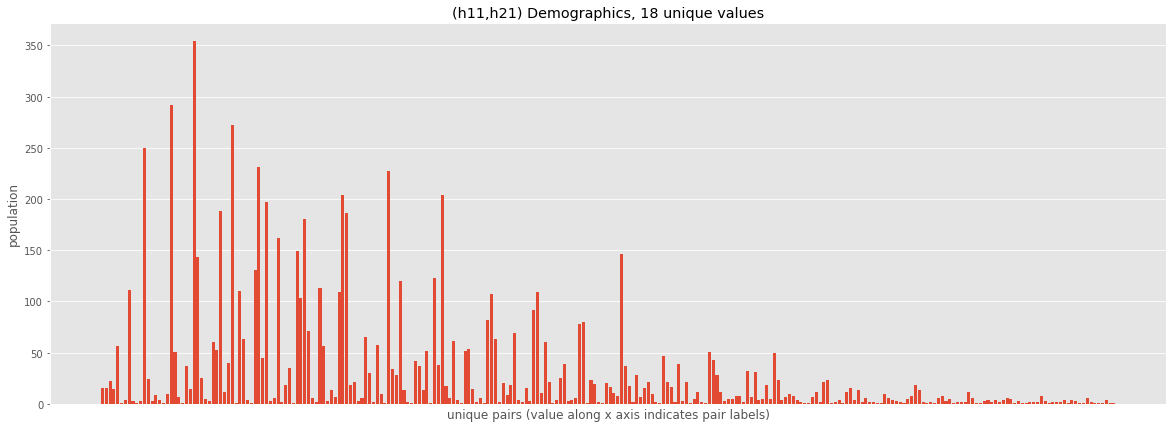

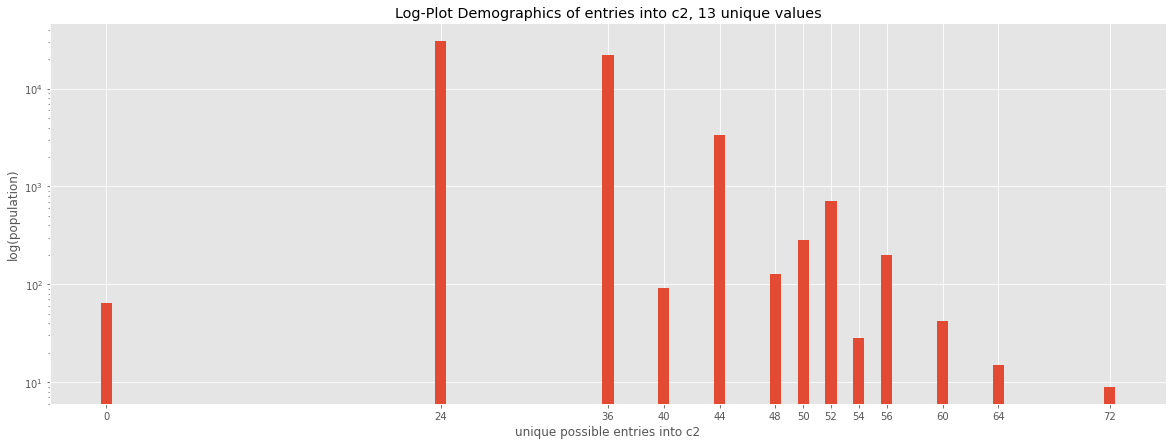

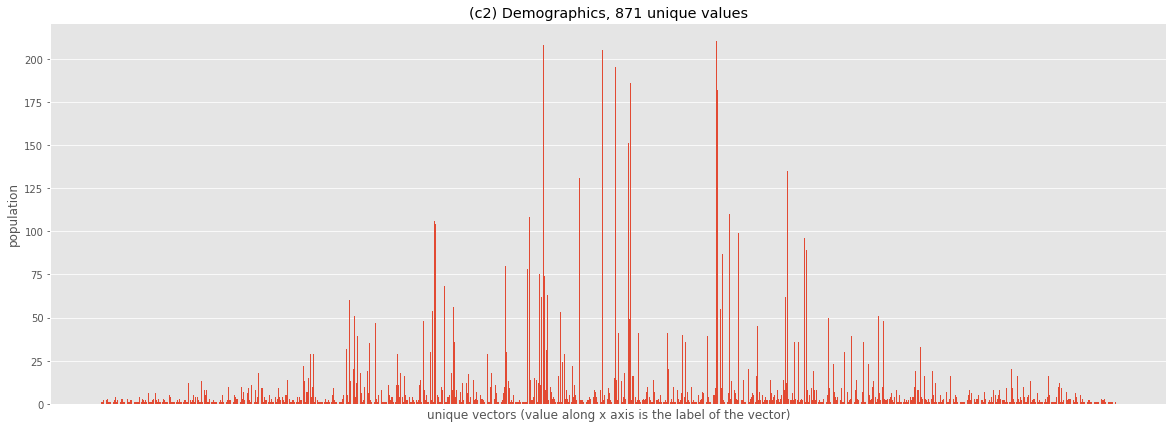

In [5]:
figsize =(20,7)

get_xrange = lambda x: range(np.max(x)+1)

h21_ticks = range(0,max(h21_unique)+1,5)

f,ax = plt.subplots(nrows=1,ncols=2,figsize=figsize)
ax[0].bar(get_xrange(h11_unique),h11_population)
ax[0].set_xticks(h11_unique)
ax[0].set_xlabel('h11 value')
ax[0].set_ylabel('Population')
ax[0].set_title('h11 Demographics, {} unique values'.format(len(h11_unique)))

ax[1].bar(get_xrange(h21_unique),h21_population)
ax[1].set_xticks(h21_ticks)
ax[1].set_xlabel('h21 value')
ax[1].set_ylabel('Population')
ax[1].set_title('h21 Demographics, {} unique values'.format(len(h21_unique)))
plt.show()

f = plt.figure(figsize=figsize)
plt.bar(get_xrange(n_unique_pairs-1),h11h21pop) # range starts from 0
plt.xticks([])
plt.ylabel('population')
plt.xlabel('unique pairs (value along x axis indicates pair labels)')
plt.title('(h11,h21) Demographics, {} unique values'.format(len(h11_unique)))
plt.show()

f = plt.figure(figsize=figsize)
plt.bar(unique_c2,c2_counts)
plt.yscale('log')
plt.xticks(unique_c2)
plt.ylabel('log(population)')
plt.xlabel('unique possible entries into c2')
plt.title('Log-Plot Demographics of entries into c2, {} unique values'.format(len(unique_c2)))
plt.show()

f = plt.figure(figsize=figsize)
plt.bar(get_xrange(n_unique_entries-1),c2_pop_entries) # range starts from 0
plt.xticks([])
plt.ylabel('population')
plt.xlabel('unique vectors (value along x axis is the label of the vector)')
plt.title('(c2) Demographics, {} unique values'.format(n_unique_entries))
plt.show()

## Building Scalar Features from the Configuration Matrices

The following scalar features can be constructed canonically from the configuration matrix.

**rank_matrix**: the rank of the configuration matrix

**norm_matrix**: the Froebenius norm of the configuration matrix

The configuration matrices are generically rectangular, i.e. number of rows is not equal to the number
of columns. 

We can however associate a square matrix to a rectangular matrix by matrix multiplication.
Define _matrix_square_ _via_ :
\begin{equation}
m = q\cdot q^t
\end{equation}
$m$ is a square matrix and we can compute its determinant and trace. 

This leads to the following new features:

**det_matrix**: the determinant of the square of configuration matrix

**trace_matrix**: the trace of the square configuration matrix, this is the square of _norm_matrix_

Next, we can also compute the eigenvalues of $m$ and extract the minimum, maximum and mean eigenvalue for each $m$.

Eigenvalues in general can be complex. So we will take the absolute value of eigenvalues and take their min, max, mean.

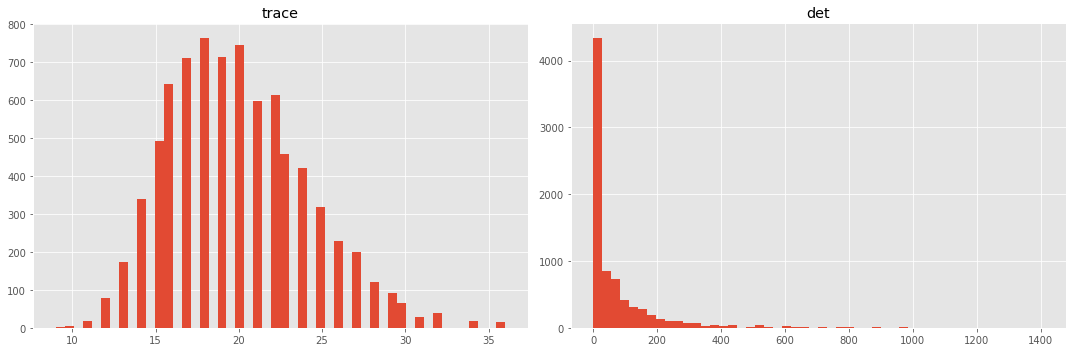

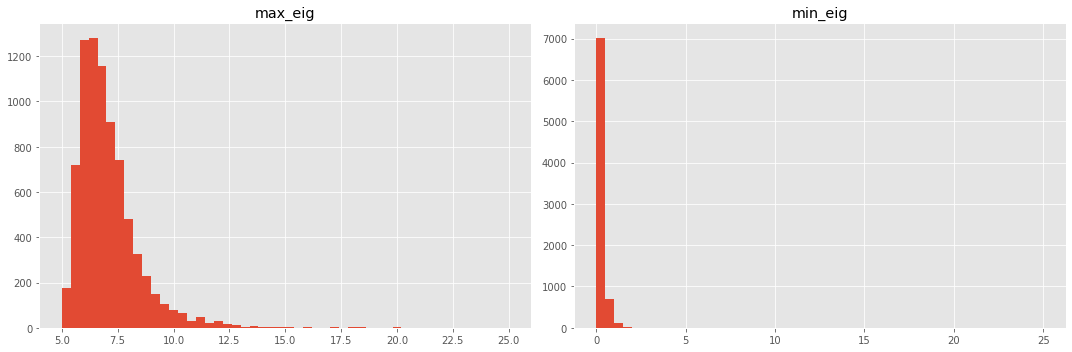

In [6]:
matrix_square = lambda x: x @ np.transpose(x) # helper to compute x.x^t
square_matrices = cicy['matrix'].apply(matrix_square)

dets, traces = square_matrices.apply(np.linalg.det), square_matrices.apply(np.trace)

eigen = lambda x: np.abs(np.linalg.eig(x)[0]) # absolute value of eigenvalues
eigenvalues = square_matrices.apply(eigen)

max_eig, min_eig = eigenvalues.apply(np.max),eigenvalues.apply(np.min)
mean_eig = eigenvalues.apply(np.mean)

cicy['max_eig'],cicy['min_eig']= max_eig, min_eig 
cicy['mean_eig'] = mean_eig

cicy['trace'],cicy['det']= traces,dets

cicy[['trace','det']].hist(bins=50,figsize=(15,5))
plt.tight_layout()
plt.show()

cicy[['max_eig','min_eig']].hist(bins=50,figsize=(15,5))
plt.tight_layout()
plt.show()

The trace looks normally distributed, but the determinant, maximum and minimum eigenvalues are heavily skewed (as a natural consequence, 
so is the mean, though we don't show it here). 

Since the determinant is the product of eigenvalues, it is not surprising that if one is skewed they are all skewed.

We therefore apply a **box-cox transformation** on the determinant and eigenvalue features to make them normally distributed.

See [page 3 of this file](https://www.ime.usp.br/~abe/lista/pdfm9cJKUmFZp.pdf) for details including how to use box-cox for negative values
as well.

In [7]:
from scipy.stats import boxcox

# shift the variable to make all values positive so that box-cox can work
def boxcox_shift(x,eps=1e-7):
    if np.min(x)>0:
        return x
    else:
        return x-np.min(x)+eps

# retain the transformed variabled, not the values of transformation parameter

boxcox_transformed = lambda x: boxcox(x)[0]

In [8]:
compose = lambda f,g,x :f(g(x))

dets = compose(boxcox_transformed,boxcox_shift,dets)

max_eig = compose(boxcox_transformed,boxcox_shift,max_eig)

mean_eig = compose(boxcox_transformed,boxcox_shift,mean_eig)

min_eig = compose(boxcox_transformed,boxcox_shift,min_eig)

In [9]:
cicy['det']=dets
cicy['max_eig'],cicy['mean_eig']= max_eig, mean_eig 
cicy['min_eig'] = min_eig

## Statistics of scalar features

In [10]:
## Isolate scalar features for ranking correlations with the target variables h11 and h21

scalar_features = ['h11','h21','num_cp','num_eqs','rank_matrix','norm_matrix','trace','det','max_eig','min_eig','mean_eig']
scalar_features_only = cicy[scalar_features]

display(scalar_features_only)

h11  h21  num_cp  num_eqs  rank_matrix  norm_matrix  trace       det  \
1      15   15      15       18           14     6.000000     36 -5.787134   
2      15   15      15       18           14     6.000000     36 -5.787134   
3      15   15      15       18           14     6.000000     36 -5.787135   
4      15   15      15       18           14     6.000000     36 -5.787135   
5      15   15      15       18           14     6.000000     36 -5.787134   
...   ...  ...     ...      ...          ...          ...    ...       ...   
7886    2   86       2        3            2     4.472136     20  4.628426   
7887    2   86       2        1            1     4.472136     20 -5.787135   
7888    2   86       2        2            2     4.582576     21  5.902809   
7889    1   89       1        2            1     4.472136     20  3.841119   
7890    1  101       1        1            1     5.000000     25  4.207550   

       max_eig   min_eig  mean_eig  
1     0.467027 -4.654812  0.239293  
2     0.467027 -4.654812  0.239293  
3     0.467027 -4.654812  0.239293  
4     0.467027 -4.654812  0.239293  
5     0.467027 -4.654812  0.239293  
...        ...       ...       ...  
7886  0.483304  0.595784  0.246321  
7887  0.483513 -4.654812  0.246321  
7888  0.483164  1.502599  0.246325  
7889  0.483513  4.151954  0.246341  
7890  0.483882  4.576829  0.246342  

[7890 rows x 11 columns]

### Histograms of Features

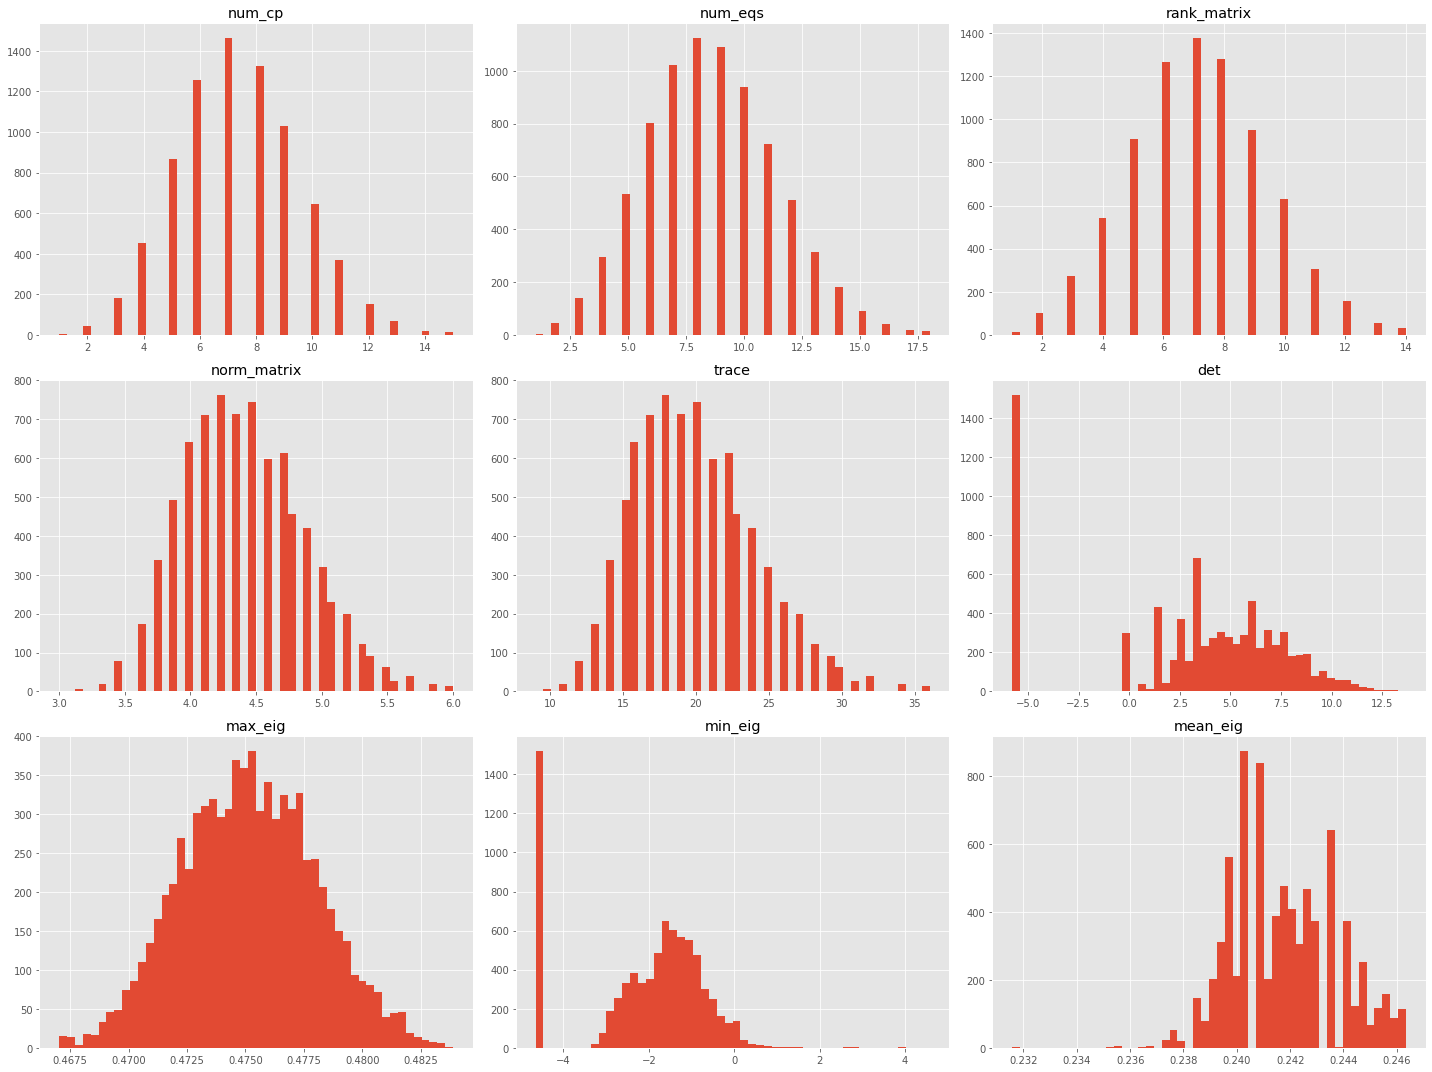

In [11]:
targets = ['h11','h21']
%matplotlib inline
scalar_features_only.loc[:,~scalar_features_only.columns.isin(targets)].hist(bins=50,figsize=(20,15))
plt.tight_layout()
plt.show()

We see that the determinant and eigenvalue variable distributions are far less skewed after the box-cox transformation

### Correlation Matrix

In [12]:
correlation_matrix = scalar_features_only.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)

We can also visualize these correlations as a scatter plot

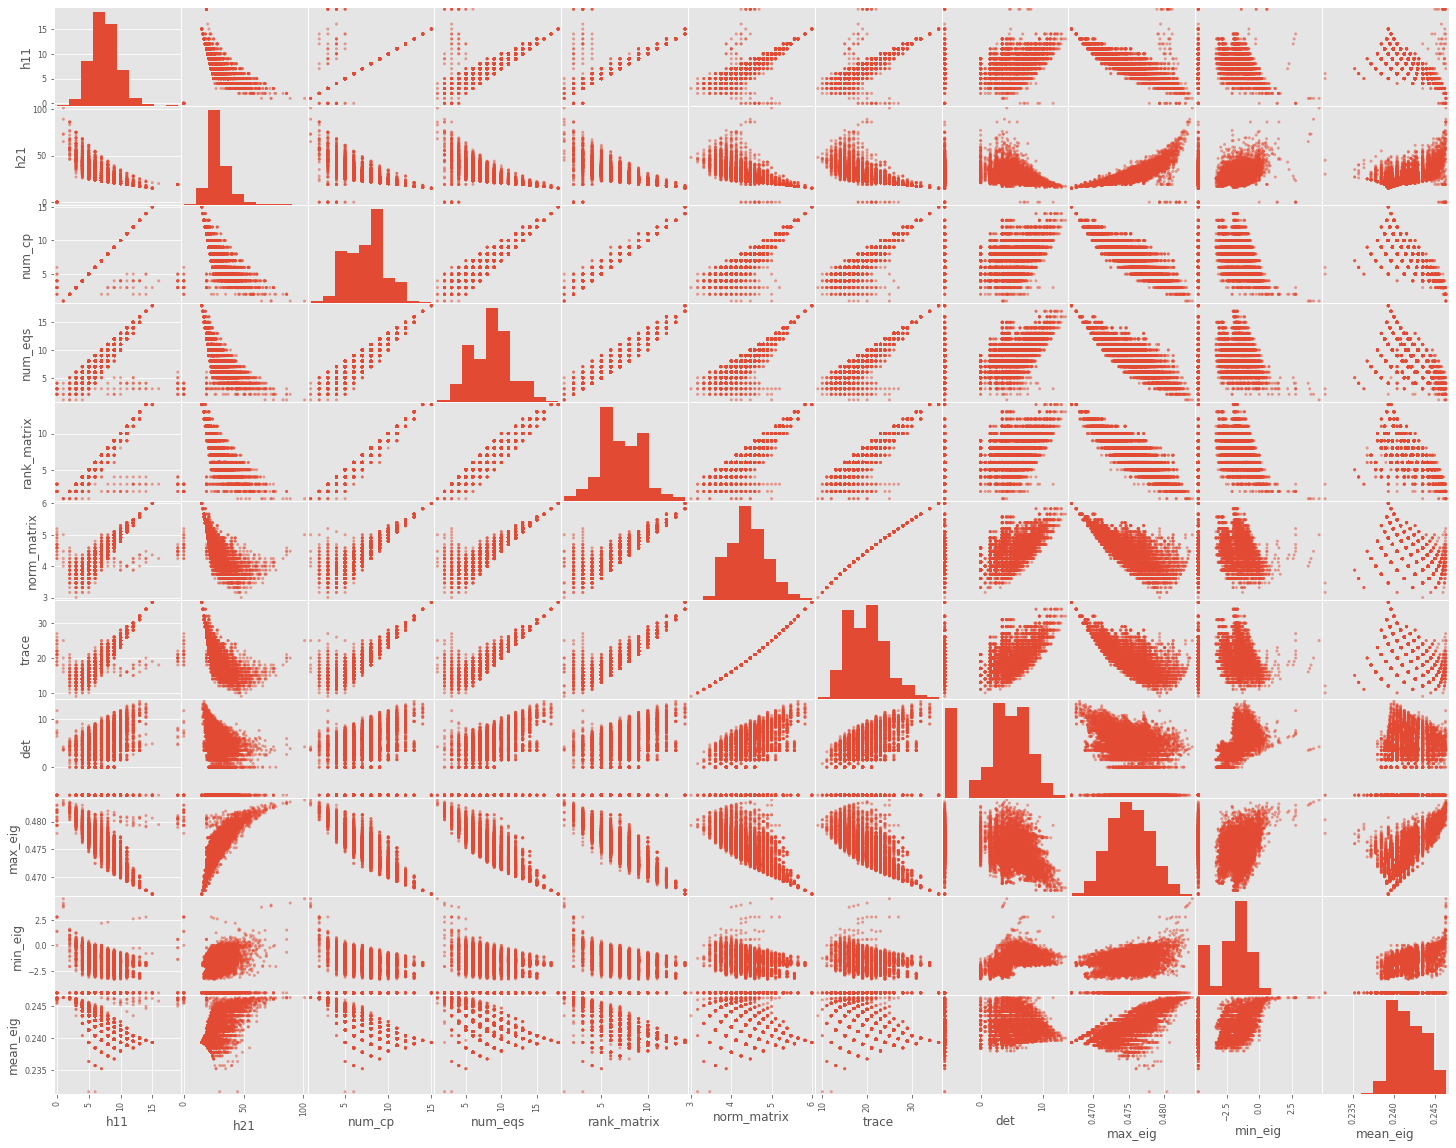

In [13]:
scatter_matrix(scalar_features_only,figsize=(25,20))

plt.show()

## Correlations with Hodge Numbers

The features best (anti) correlated with $h^{1,1}$ and $h^{2,1}$ are:

**num_cp**, **num_eqs**, **rank_matrix**, **norm_matrix**, **trace**, **max_eig**

Since the dataset is very skewed in population, we will visualize the correlations with Hodge numbers 
using scatter-plots. The size of the points is correlated to the number of elements of the dataset with a
given $(h,featurevalue)$ pairing.

In [14]:
def pointsize(df,feature_a,feature_h):
    unique_pairs = df.groupby([feature_a,feature_h]).groups
    scattersize = []
    for a,h in zip(df[feature_a],df[feature_h]):
        scattersize.append(len(unique_pairs[(a,h)]))
    return scattersize

def draw_figure(df,feature_a,feature_b,feature_h,figsize=(20,7)):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=figsize)  
    for i,feat in enumerate([feature_a,feature_b]):
        s = pointsize(df,feat,feature_h)
        im=axes[i].scatter(df[feat], df[feature_h],alpha=0.65,s=s,c=s)
        axes[i].set_xlabel(feat)
    axes[0].set_ylabel(feature_h)
    plt.colorbar(im)
    fig.tight_layout()

### Correlations with $h^{1,1}$

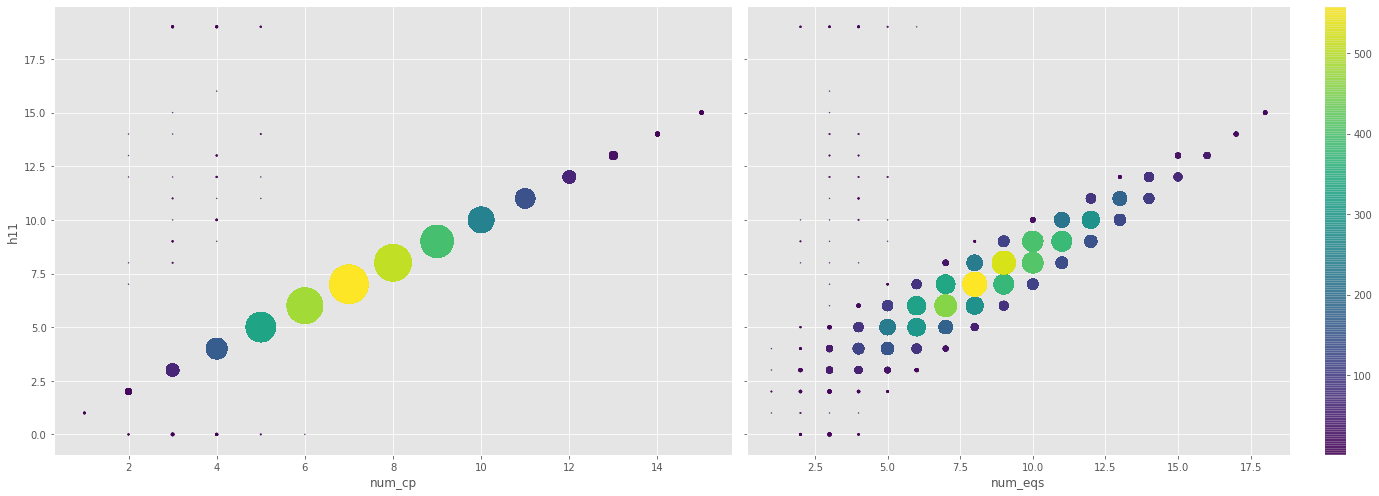

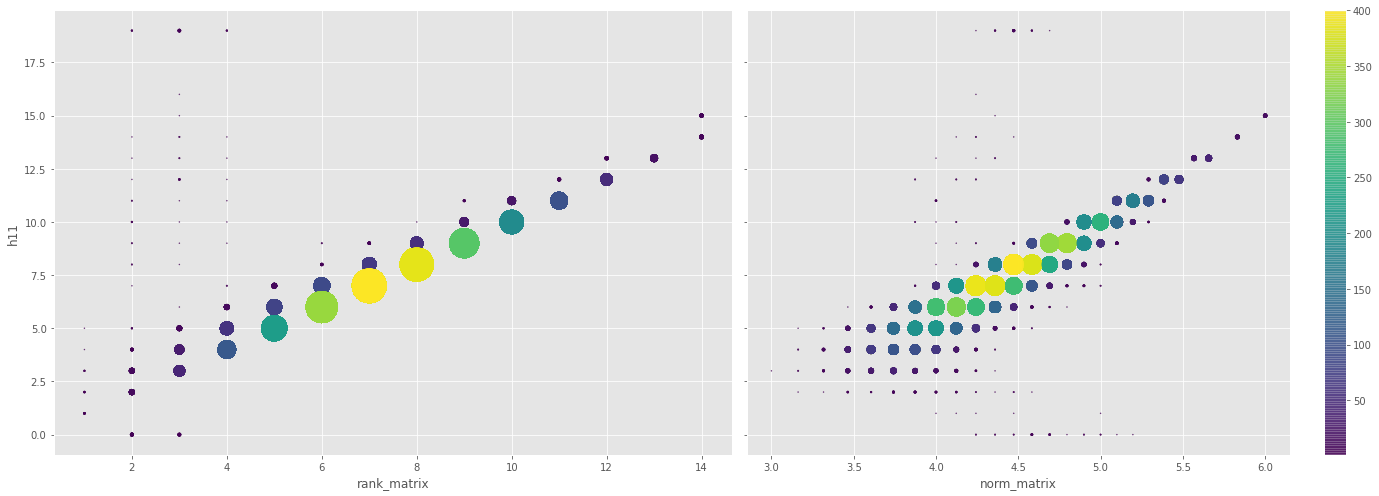

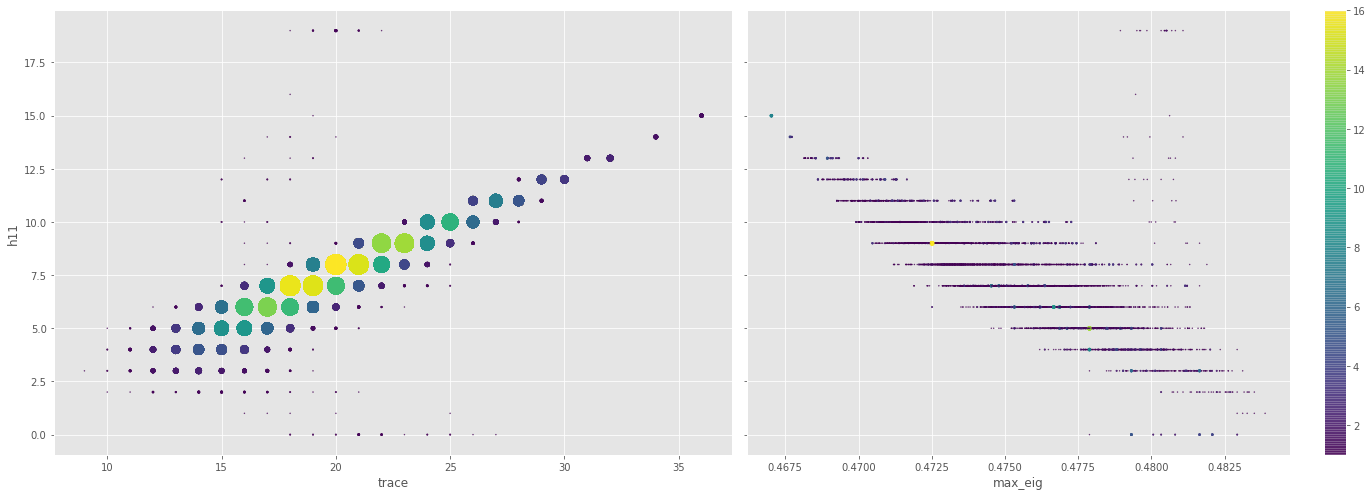

In [15]:
draw_figure(cicy,'num_cp','num_eqs','h11')
draw_figure(cicy,'rank_matrix','norm_matrix','h11')
draw_figure(cicy,'trace','max_eig','h11')

## Correlations with $h^{2,1}$

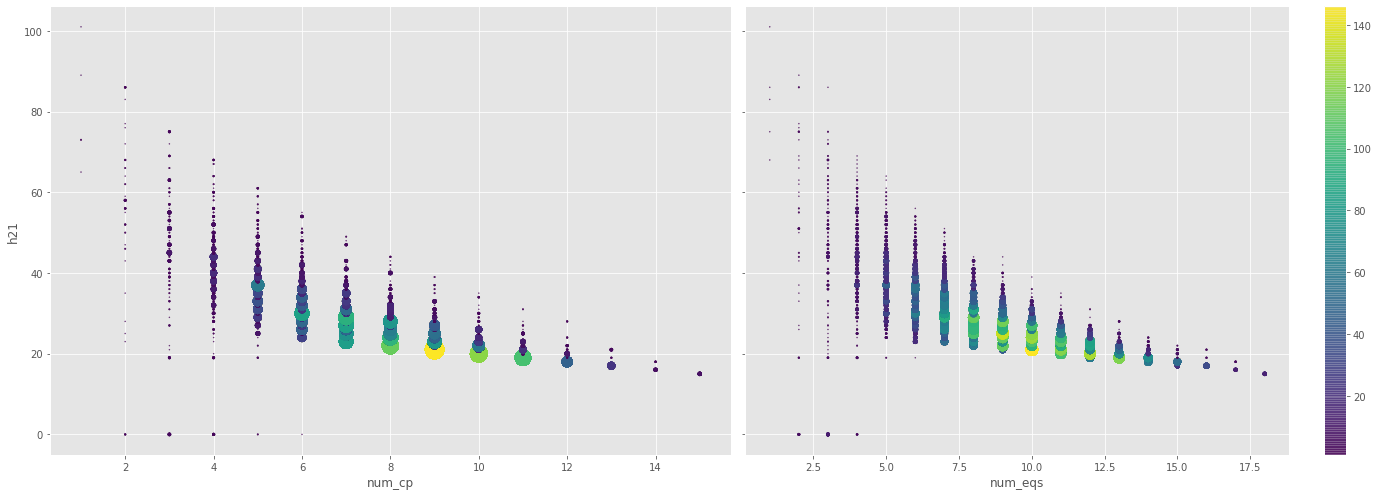

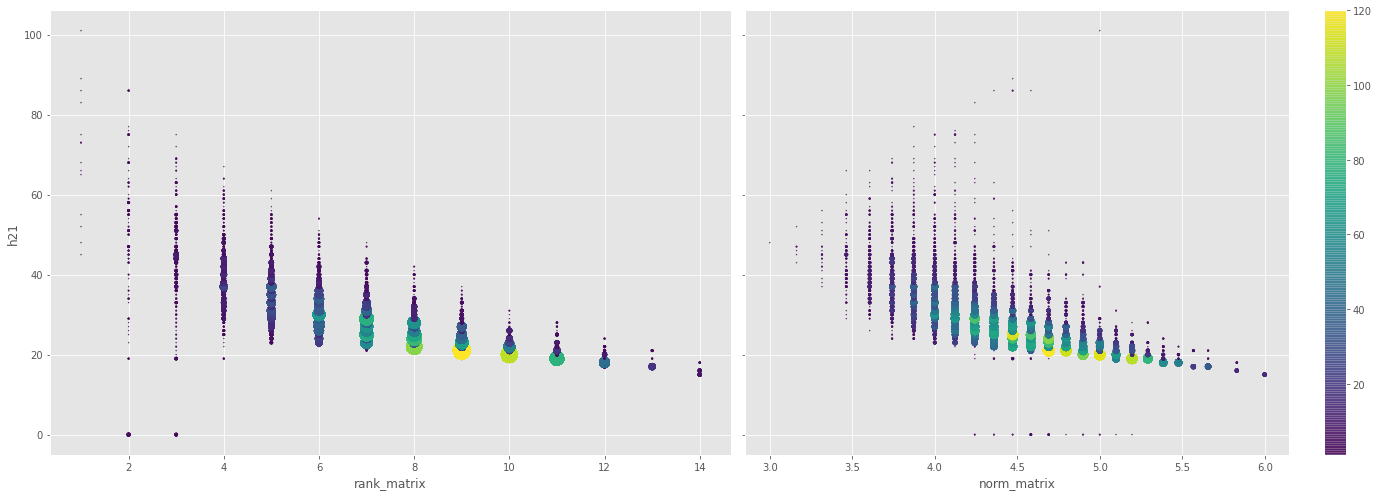

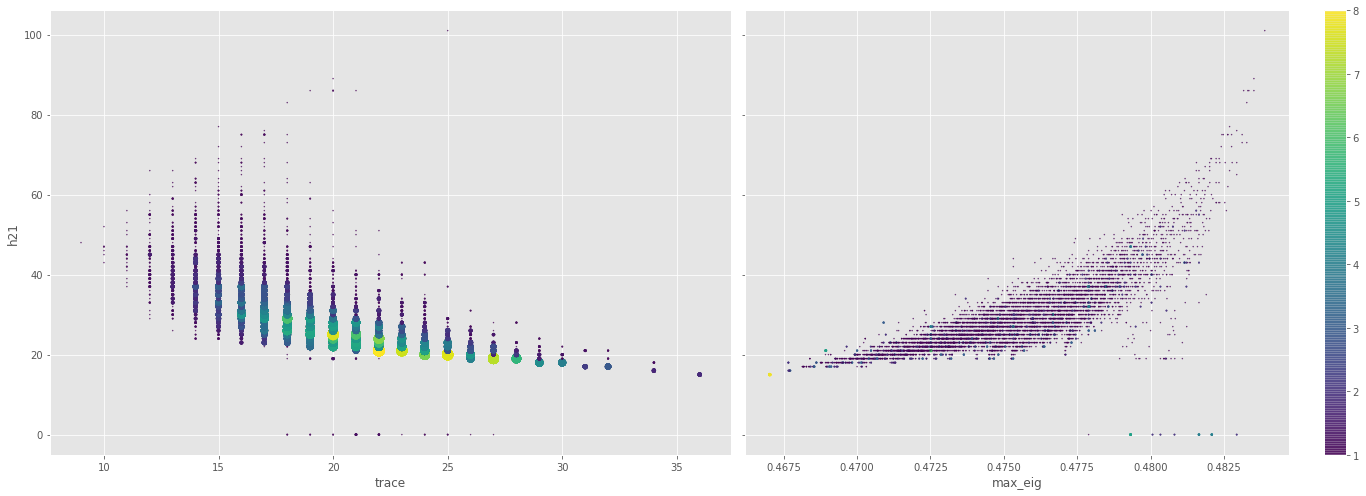

In [16]:
draw_figure(cicy,'num_cp','num_eqs','h21')
draw_figure(cicy,'rank_matrix','norm_matrix','h21')
draw_figure(cicy,'trace','max_eig','h21')